# Import libraries

In [1]:
#Importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
pd.options.display.float_format='{:,.2f}'.format
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset

In [2]:
#Importing Data
df=pd.read_csv("telecom_churn_data.csv")
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,...,0,1.00,1.00,1.00,nan,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,...,0,nan,1.00,1.00,nan,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,...,0,nan,nan,nan,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,...,0,nan,nan,nan,nan,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,...,0,0.00,nan,nan,nan,1526,0.00,0.00,0.00,0.00


# Data cleaning and preparation

We have to create the labels based on the conditions given. Lets check if any null values are present in the deciding features. If deciding features do not have nulls, we will go ahead and create labels

In [3]:
print ("Null values in incoming calls>>>",df.total_ic_mou_9.isnull().sum())
print("Null values in outgoing calls>>>",df.total_og_mou_9.isnull().sum())
print("Null values in 2mb data internet>>>",df.vol_2g_mb_9.isnull().sum())
print("Null values in 3mb data internet>>>",df.vol_3g_mb_9.isnull().sum())
print("Total Recharge amount null for 6 month>>>" , df.total_rech_amt_6.isnull().sum())
print("Total Recharge amount null for 7 month>>>" , df.total_rech_amt_6.isnull().sum())

Null values in incoming calls>>> 0
Null values in outgoing calls>>> 0
Null values in 2mb data internet>>> 0
Null values in 3mb data internet>>> 0
Total Recharge amount null for 6 month>>> 0
Total Recharge amount null for 7 month>>> 0


In [4]:
#Creating Label
df['churn']=0
df.loc[(df['total_ic_mou_9']==0.0) & (df['total_og_mou_9']==0.0) & (df['vol_2g_mb_9']==0.0) & (df['vol_3g_mb_9']==0.0),'churn']=1

Now as instructed lets delete 9th month features

In [5]:
df=df[df.columns[~df.columns.str.endswith("_9")]]

# Filter high values customers

Lets filter only high value customers as required based on the condition mentioned 

In [6]:
df['avg_rec_6_7']=(df.total_rech_amt_6+df.total_rech_amt_7)/2
threshold_amount=np.percentile(df['avg_rec_6_7'],70)
df=df[df['avg_rec_6_7']>=threshold_amount]
df.shape

(30011, 174)

In [7]:
print('churn %',(len(df[df['churn']==1])/len(df.index))*100)

churn % 8.64016527273333


We are left with around 30k high value customer data.But we have only 8.6 % of Churn class. Its a clear case of class imbalance. We will derive some usefull features based on business understanding and handle null. Later we will try to handle class imbalance with appropriate technique

# Deriving data features and reducing dimensionality

In [8]:
df['monthly_data_packs_6']=df['monthly_2g_6']+df['monthly_3g_6']
df['monthly_data_packs_7']=df['monthly_2g_7']+df['monthly_3g_7']
df['monthly_data_packs_8']=df['monthly_2g_8']+df['monthly_3g_8']
df['sachet_data_packs_6']=df['sachet_2g_6']+df['sachet_3g_6']
df['sachet_data_packs_7']=df['sachet_2g_7']+df['sachet_3g_7']
df['sachet_data_packs_8']=df['sachet_2g_8']+df['sachet_3g_8']
df['arpu_data_6']=df['arpu_2g_6']+df['arpu_3g_6']
df['arpu_data_7']=df['arpu_2g_7']+df['arpu_3g_7']
df['arpu_data_8']=df['arpu_2g_8']+df['arpu_3g_8']
df['vol_data_6']=df['vol_2g_mb_6']+df['vol_3g_mb_6']
df['vol_data_7']=df['vol_2g_mb_7']+df['vol_3g_mb_7']
df['vol_data_8']=df['vol_2g_mb_8']+df['vol_3g_mb_8']
df['total_local_oc_mins_6']=df['loc_og_t2t_mou_6']+df['loc_og_t2m_mou_6']+df['loc_og_t2f_mou_6']+df['loc_og_mou_6']
df['total_local_oc_mins_7']=df['loc_og_t2t_mou_7']+df['loc_og_t2m_mou_7']+df['loc_og_t2f_mou_7']+df['loc_og_mou_7']
df['total_local_oc_mins_8']=df['loc_og_t2t_mou_8']+df['loc_og_t2m_mou_8']+df['loc_og_t2f_mou_8']+df['loc_og_mou_8']
df['total_std_oc_mins_6']=df['std_og_t2t_mou_6']+df['std_og_t2m_mou_6']+df['std_og_t2f_mou_6']+df['std_og_mou_6']
df['total_std_oc_mins_7']=df['std_og_t2t_mou_7']+df['std_og_t2m_mou_7']+df['std_og_t2f_mou_7']+df['std_og_mou_7']
df['total_std_oc_mins_8']=df['std_og_t2t_mou_8']+df['std_og_t2m_mou_8']+df['std_og_t2f_mou_8']+df['std_og_mou_8']
df['total_customer_calls_6']=df['loc_og_t2c_mou_6']+df['std_og_t2c_mou_6']
df['total_customer_calls_7']=df['loc_og_t2c_mou_7']+df['std_og_t2c_mou_7']
df['total_customer_calls_8']=df['loc_og_t2c_mou_8']+df['std_og_t2c_mou_8']
df['total_local_ic_mins_6']=df['loc_ic_t2t_mou_6']+df['loc_ic_t2m_mou_6']+df['loc_ic_t2f_mou_6']+df['loc_ic_mou_6']
df['total_local_ic_mins_7']=df['loc_ic_t2t_mou_7']+df['loc_ic_t2m_mou_7']+df['loc_ic_t2f_mou_7']+df['loc_ic_mou_7']
df['total_local_ic_mins_8']=df['loc_ic_t2t_mou_8']+df['loc_ic_t2m_mou_8']+df['loc_ic_t2f_mou_8']+df['loc_ic_mou_8']
df['total_std_ic_mins_6']=df['std_ic_t2t_mou_6']+df['std_ic_t2m_mou_6']+df['std_ic_t2f_mou_6']+df['std_ic_mou_6']+df['std_ic_t2o_mou_6']
df['total_std_ic_mins_7']=df['std_ic_t2t_mou_7']+df['std_ic_t2m_mou_7']+df['std_ic_t2f_mou_7']+df['std_ic_mou_7']+df['std_ic_t2o_mou_7']
df['total_std_ic_mins_8']=df['std_ic_t2t_mou_8']+df['std_ic_t2m_mou_8']+df['std_ic_t2f_mou_8']+df['std_ic_mou_8']+df['std_ic_t2o_mou_8']


In [9]:
#dropping features from which new features were derived
df=df.drop(['monthly_2g_6','monthly_2g_7','monthly_2g_8','monthly_3g_6','monthly_3g_7','monthly_3g_8','sachet_2g_6','sachet_2g_7'
            ,'sachet_2g_8','sachet_3g_6','sachet_3g_7','sachet_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_3g_6','arpu_3g_7'
            ,'arpu_3g_8','vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','loc_og_t2t_mou_6',
            'loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_og_t2t_mou_6',
            'loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_og_t2f_mou_6',
            'loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_og_mou_6',
            'loc_og_mou_7','loc_og_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7',
            'std_og_t2t_mou_8','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7',
            'std_og_t2t_mou_8','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_og_t2f_mou_6','std_og_t2f_mou_7',
            'std_og_t2f_mou_8','std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_og_mou_6','std_og_mou_7',
            'std_og_mou_8','std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8',
            'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
           'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
           'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8',
           'std_og_mou_6','std_og_mou_7','std_og_mou_8','sep_vbc_3g'],axis=1)

In [10]:
#Dropping rows with all NANs
df=df.dropna(axis=1, how='all')

In [11]:
#deleting columns which has only one value that do not help our analysis
df=df.loc[:,df.apply(pd.Series.nunique)!=1]

In [12]:
#deriving some more features
df['special_pack_user_6']=df['night_pck_user_6'] + df['fb_user_6']
df['special_pack_user_7']=df['night_pck_user_7'] + df['fb_user_7']
df['special_pack_user_8']=df['night_pck_user_8'] + df['fb_user_8']
df['count_rech_data_6']=df['count_rech_2g_6']+df['count_rech_3g_6']
df['count_rech_data_7']=df['count_rech_2g_7']+df['count_rech_3g_7']
df['count_rech_data_8']=df['count_rech_2g_8']+df['count_rech_3g_8']

In [13]:
#Below we can see many columns with 60% and more nulls. We can drop these
df.isnull().mean().sort_values(ascending=False)

total_rech_data_6          0.62
count_rech_3g_6            0.62
count_rech_data_6          0.62
date_of_last_rech_data_6   0.62
fb_user_6                  0.62
special_pack_user_6        0.62
arpu_data_6                0.62
night_pck_user_6           0.62
max_rech_data_6            0.62
av_rech_amt_data_6         0.62
count_rech_2g_6            0.62
arpu_data_7                0.61
night_pck_user_7           0.61
av_rech_amt_data_7         0.61
count_rech_3g_7            0.61
count_rech_2g_7            0.61
max_rech_data_7            0.61
total_rech_data_7          0.61
count_rech_data_7          0.61
date_of_last_rech_data_7   0.61
special_pack_user_7        0.61
fb_user_7                  0.61
count_rech_2g_8            0.61
fb_user_8                  0.61
max_rech_data_8            0.61
count_rech_3g_8            0.61
total_rech_data_8          0.61
av_rech_amt_data_8         0.61
date_of_last_rech_data_8   0.61
night_pck_user_8           0.61
                           ... 
total_og

In [14]:
df=df.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','max_rech_data_6','max_rech_data_7','max_rech_data_8',
          'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',
          'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','night_pck_user_6','night_pck_user_7','night_pck_user_8',
          'fb_user_6','fb_user_7','fb_user_8'],axis=1)

In [15]:
df=df.drop(['count_rech_data_6','count_rech_data_7','count_rech_data_8','special_pack_user_6','special_pack_user_7','special_pack_user_8',
           'arpu_data_6','arpu_data_7','arpu_data_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis=1)

In [16]:
#lets derive number of days from last recharged
df.loc[df['date_of_last_rech_8'].isnull(),'date_of_last_rech_8']=0
df.loc[df['date_of_last_rech_7'].isnull(),'date_of_last_rech_7']=0
df.loc[df['date_of_last_rech_6'].isnull(),'date_of_last_rech_6']=0

In [17]:
df['date_of_last_rech_8']=df['date_of_last_rech_8'].map(lambda x: pd.to_datetime(x))
df['date_of_last_rech_7']=df['date_of_last_rech_7'].map(lambda x: pd.to_datetime(x))
df['date_of_last_rech_6']=df['date_of_last_rech_6'].map(lambda x: pd.to_datetime(x))


In [18]:
df['last_rech_month']=df['date_of_last_rech_8'].map(lambda x : x.date())
df['last_rech_month']=df[['last_rech_month','date_of_last_rech_7']].apply(lambda x : x.last_rech_month.date() if(str(x.last_rech_month.date())!="1970-01-01") else x.date_of_last_rech_7 , axis=1)
df['last_rech_month']=df[['last_rech_month','date_of_last_rech_6']].apply(lambda x : x.last_rech_month.date() if(str(x.last_rech_month.date())!="1970-01-01") else x.date_of_last_rech_6 , axis=1)

In [19]:
last_date=pd.to_datetime("2014-08-31").date()
df['Number_days_not_rech']=df['last_rech_month'].map(lambda x :str(last_date -x.date()).split(" ")[0] if(x.date()!=last_date) else 0)

In [20]:
df=df.drop(['last_rech_month','mobile_number','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1)
df['Number_days_not_rech']=pd.to_numeric(df['Number_days_not_rech'])
df['Number_days_not_rech'].value_counts().head(5)

0    6670
1    4790
2    3376
3    2948
6    2209
Name: Number_days_not_rech, dtype: int64

In [21]:
df.isnull().sum()
#Now if we see we don't have columns with huge nulls. We can drop these rows having nulls as we have derived sufficient features

arpu_6                      0
arpu_7                      0
arpu_8                      0
onnet_mou_6               316
onnet_mou_7               303
onnet_mou_8               938
offnet_mou_6              316
offnet_mou_7              303
offnet_mou_8              938
roam_ic_mou_6             316
roam_ic_mou_7             303
roam_ic_mou_8             938
roam_og_mou_6             316
roam_og_mou_7             303
roam_og_mou_8             938
isd_og_mou_6              316
isd_og_mou_7              303
isd_og_mou_8              938
spl_og_mou_6              316
spl_og_mou_7              303
spl_og_mou_8              938
og_others_6               316
og_others_7               303
og_others_8               938
total_og_mou_6              0
total_og_mou_7              0
total_og_mou_8              0
total_ic_mou_6              0
total_ic_mou_7              0
total_ic_mou_8              0
                         ... 
aug_vbc_3g                  0
jul_vbc_3g                  0
jun_vbc_3g

In [22]:
df=df.dropna(axis=0,how='any')

In [23]:
#Now we have handled all null and derived some important features
df.isnull().sum()

arpu_6                    0
arpu_7                    0
arpu_8                    0
onnet_mou_6               0
onnet_mou_7               0
onnet_mou_8               0
offnet_mou_6              0
offnet_mou_7              0
offnet_mou_8              0
roam_ic_mou_6             0
roam_ic_mou_7             0
roam_ic_mou_8             0
roam_og_mou_6             0
roam_og_mou_7             0
roam_og_mou_8             0
isd_og_mou_6              0
isd_og_mou_7              0
isd_og_mou_8              0
spl_og_mou_6              0
spl_og_mou_7              0
spl_og_mou_8              0
og_others_6               0
og_others_7               0
og_others_8               0
total_og_mou_6            0
total_og_mou_7            0
total_og_mou_8            0
total_ic_mou_6            0
total_ic_mou_7            0
total_ic_mou_8            0
                         ..
aug_vbc_3g                0
jul_vbc_3g                0
jun_vbc_3g                0
churn                     0
avg_rec_6_7         

# Data Visualization

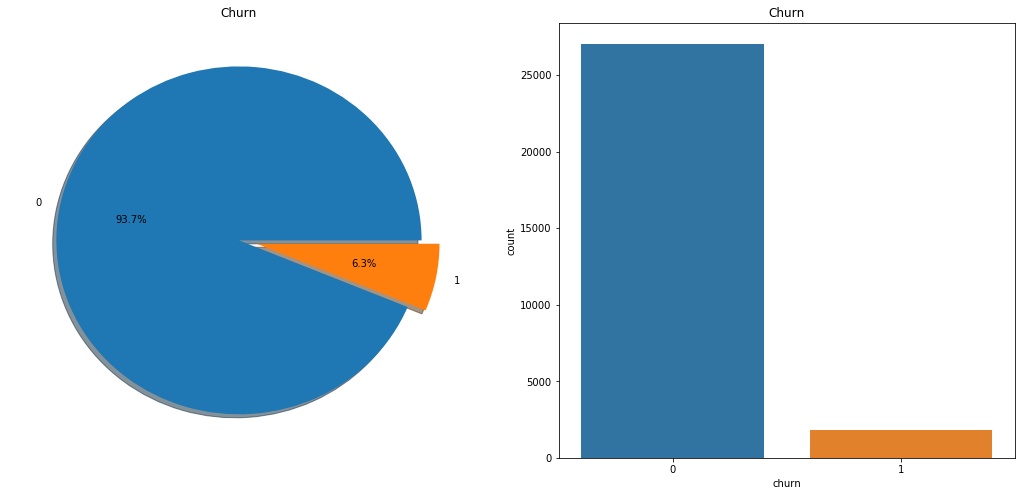

In [24]:
#Checking class distribution for churn or not
f,ax=plt.subplots(1,2,figsize=(18,8))
df['churn'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Churn')
ax[0].set_ylabel('')
sns.countplot('churn',data=df,ax=ax[1])
ax[1].set_title('Churn')
plt.show()

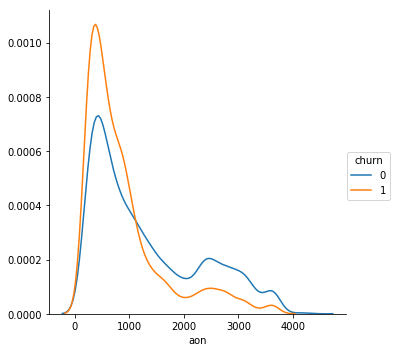

In [25]:
sns.FacetGrid(df, hue="churn", size=5).map(sns.kdeplot, "aon").add_legend()
plt.show();

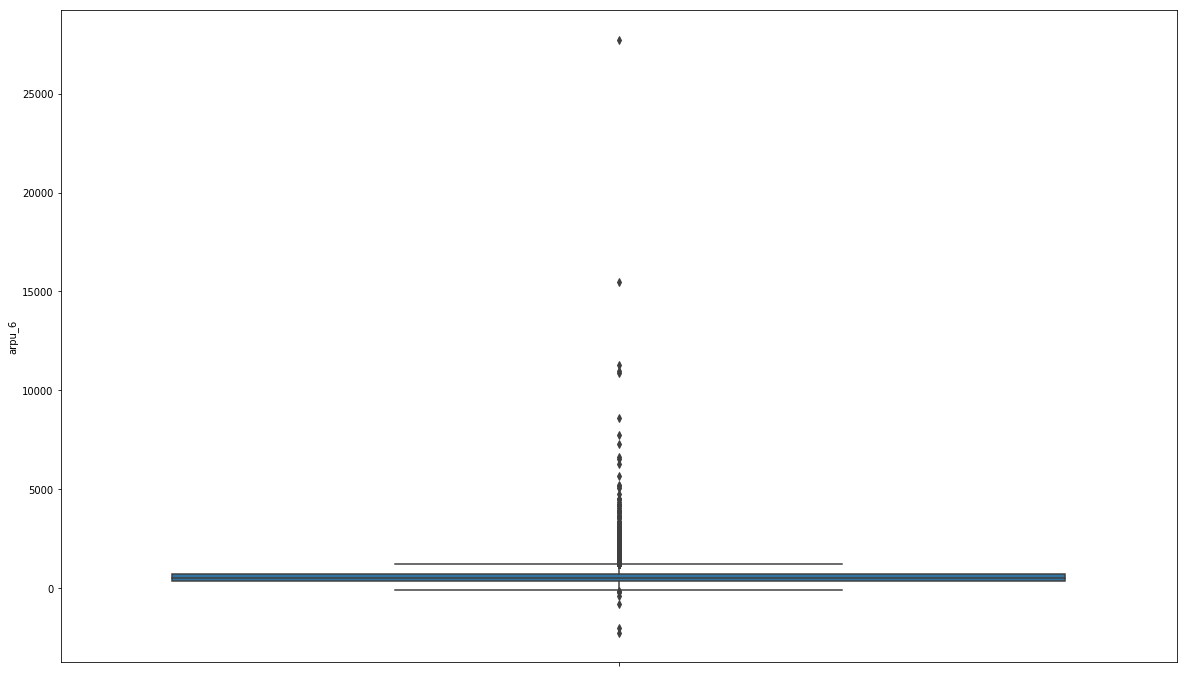

In [108]:
plt.figure(figsize=(20, 12))
sns.boxplot( y = 'arpu_6', data = df)
plt.xticks(rotation=90)
plt.show()


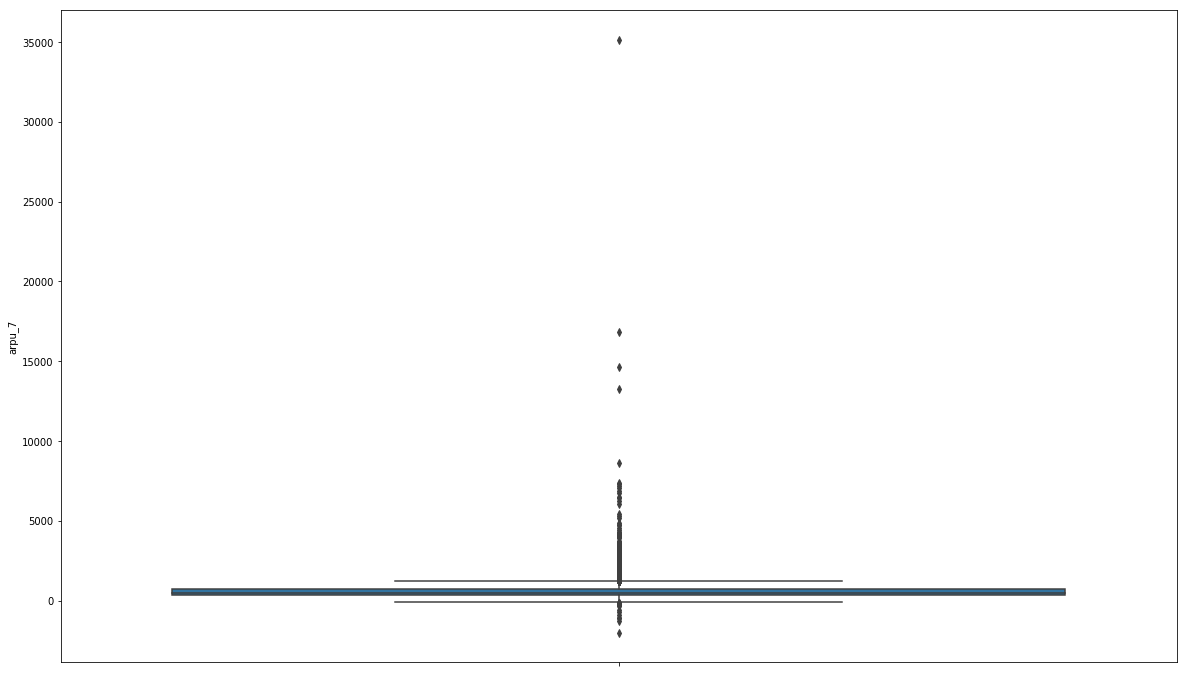

In [107]:
plt.figure(figsize=(20, 12))
sns.boxplot( y = 'arpu_7', data = df)
plt.xticks(rotation=90)
plt.show()

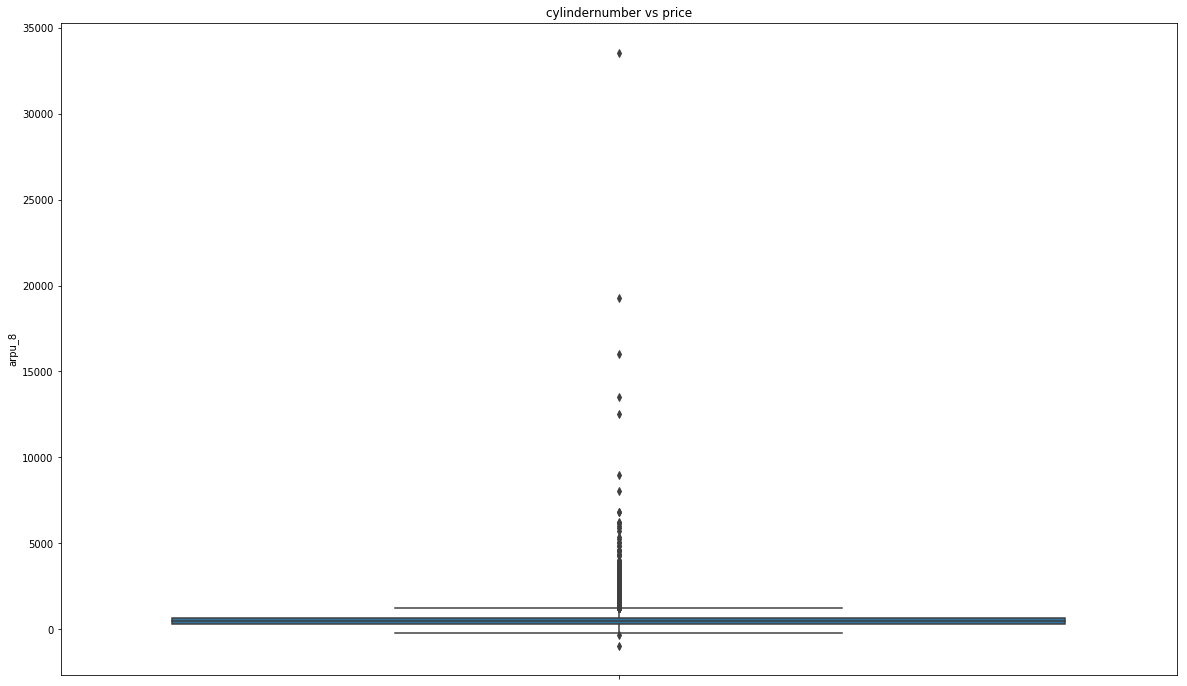

In [106]:
plt.figure(figsize=(20, 12))
sns.boxplot( y = 'arpu_8', data = df)
plt.xticks(rotation=90)
plt.show()

More is age on network , less are churns

# Removing outliers

In [29]:
#Lets see if we can remove any outliers from the data. We will use IQR technique to find any outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

arpu_6                     333.08
arpu_7                     333.25
arpu_8                     374.24
onnet_mou_6                311.04
onnet_mou_7                324.33
onnet_mou_8                277.88
offnet_mou_6               380.80
offnet_mou_7               396.16
offnet_mou_8               385.30
roam_ic_mou_6                0.00
roam_ic_mou_7                0.00
roam_ic_mou_8                0.00
roam_og_mou_6                0.00
roam_og_mou_7                0.00
roam_og_mou_8                0.00
isd_og_mou_6                 0.00
isd_og_mou_7                 0.00
isd_og_mou_8                 0.00
spl_og_mou_6                 5.21
spl_og_mou_7                 7.28
spl_og_mou_8                 6.70
og_others_6                  0.00
og_others_7                  0.00
og_others_8                  0.00
total_og_mou_6             620.06
total_og_mou_7             653.55
total_og_mou_8             637.43
total_ic_mou_6             303.98
total_ic_mou_7             298.75
total_ic_mou_8

If we observe most columns have IQR equal to zero. And as Churn class is less than non churn, we cannot afford to remove outliers as this might result in loss of churn data and our model might fail to predict churn on unseen data. Lets proceed without removing outliers and see if we can get expected results

In [30]:
#After cleaning data we see around 2% loss of churn class records which is acceptable
print('churn %',(len(df[df['churn']==1])/len(df.index))*100)

churn % 6.261044315858771


Lets split the data and do scaling of X data. Later we will handle class imbalance using SMOTE and RandomUndersampling

In [31]:
#Seperating data into x and Y
X=df.drop('churn',axis=1)
y=df['churn']

# Splitting data into test-train

In [32]:
# Splitting the data into train and test and using standard scalar to scale the data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)
col=X_train.columns
scaler = StandardScaler()
X_train_n=scaler.fit_transform(X_train)
X_test_n=scaler.fit_transform(X_test)
X_train_scale=scaler.fit_transform(X_train)
X_train_n=pd.DataFrame(X_train_n,columns=col)
X_test_n=pd.DataFrame(X_test_n,columns=col)

In [33]:
#Test and train data have same class distribution
y_test.describe()

count   8,659.00
mean        0.06
std         0.24
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: churn, dtype: float64

# Using under-sampling for class- imbalance

In [34]:
#Random Under sampling the train data to handle class imbalance
rus = RandomUnderSampler(return_indices=True)
smote = SMOTE(ratio='minority')
X_sm, y_sm,ad = rus.fit_sample(X_train_n, y_train)

In [35]:
X_sm=pd.DataFrame(X_sm,columns=col)
X_sm=pd.DataFrame(X_sm,columns=col)

In [36]:
y_sm=pd.DataFrame({'churn':y_sm})

# PCA for reducing dimensionality

Lets perform PCA to find the number of features which will represent 90% of data varience. This will also help us in feature reduction and will also remove multi collinearity between the features

In [37]:
#initializing PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [38]:
pca.fit(X_sm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [39]:
#lets check the features and there weights in first two PCA components
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':col})

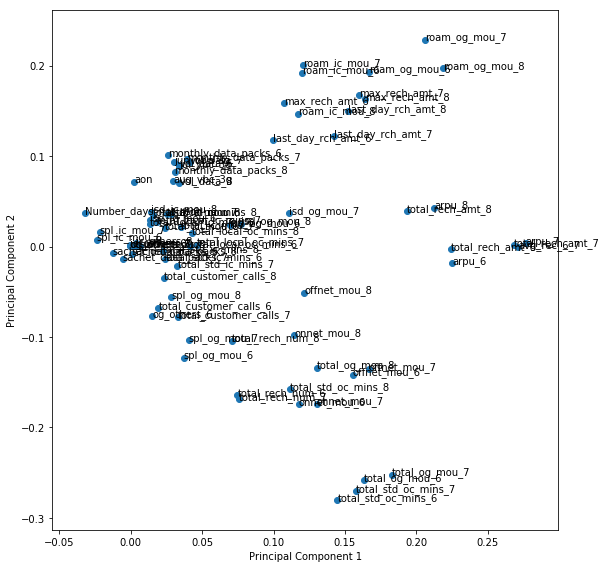

In [40]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

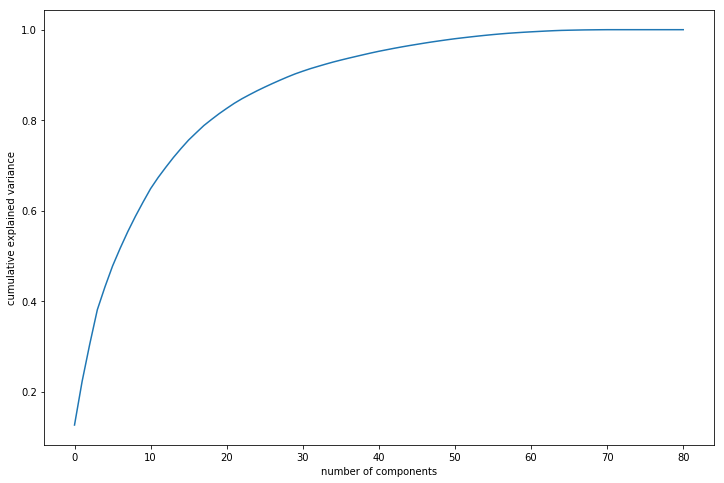

In [41]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [42]:
#from the above plot we can see that around 35 features will make 90% of varience
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=35)

In [43]:
#fitting x data with PCA
df_train_pca = pca_final.fit_transform(X_sm)
df_test_pca = pca_final.transform(X_test_n)


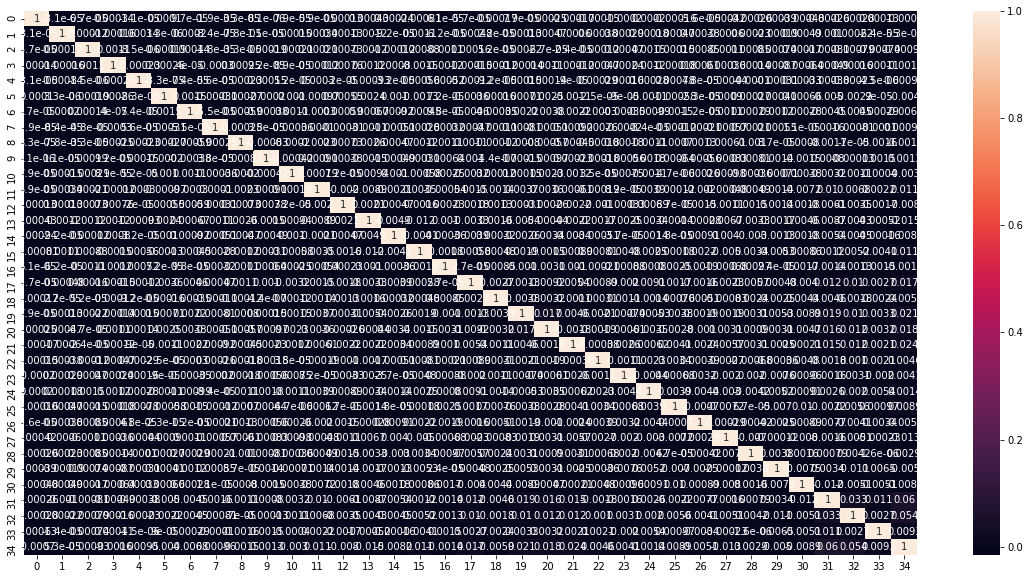

In [44]:
#Now lets see the correlation matrix with the max and min correlation
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [45]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.06006850242173073 , min corr:  -0.015281701380332902


Now lets start building different models to see which one gives us the best result.

As it costs 5-6 times to acquire new customer than retaining the present customer and 80% of companies revenue is generated from the Hign value customers on whom we are do this analysis, we cannot afford to loose these customers.
So our approach will to to detect customers before they churn and offer them appropriate plans or solve their issues.
Company wouldn't mind providing offers to customers who won't churn in case they are wrongly predicted as churners. This will in turn make these customers more loyal to the company. 
Based on the above understanding we will tune our model for high Sensitivity/Recall. In this process its okay if we have less Accuracy and Specificity. We will use Sensitivity-Specificity method to tune our models.

# Model building

In [46]:
#Lets create some functions which will help us in reusing the repeated codes
#Function to build any models by choosing optimal hyperparameters
def model_build(model,param,train_x,test_x,train_y,test_y):
    grid_search = GridSearchCV(estimator =model, param_grid = param,scoring='accuracy', 
                          cv = 2, n_jobs = -1,verbose = 1)
    grid_search.fit(train_x,train_y)
    learner_pca = grid_search.best_estimator_
    model_pca = learner_pca.fit(train_x,train_y)
    print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_,'for',model)
    y_train_pred = model_pca.predict_proba(train_x)[:,1]
    print('AUC on Train data',metrics.roc_auc_score(train_y, y_train_pred))
    y_train_pred_final = pd.DataFrame({'Churn':train_y.churn, 'Churn_Prob':y_train_pred})
    y_train_pred_final['CustID'] = train_y.index
    
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
    y_train_pred_final.head()
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()
    #Making prediction on the test data
    y_test_pred = model_pca.predict_proba(df_test_pca)[:,1]
    print('AUC on Test data',metrics.roc_auc_score(y_test, y_test_pred))
    y_test_pred_final = pd.DataFrame({'Churn':y_test, 'Churn_Prob':y_test_pred})
    y_test_pred_final['CustID'] = y_test.index
    return(y_train_pred_final,y_test_pred_final)
    

    
    

In [47]:
#Function to validate the models built
def validation_func(y_train_pred_final,y_test_pred_final):
    confusion_train = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
    confusion_test = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.final_predicted )
    print('Confusion metrics for train data',confusion_train)
    print('Confusion metrics for test data',confusion_test)
    
    #Train validations
    TP_tr = confusion_train[1,1] # true positive 
    TN_tr = confusion_train[0,0] # true negatives
    FP_tr = confusion_train[0,1] # false positives
    FN_tr = confusion_train[1,0] # false negatives
    
    
    TP = confusion_test[1,1] # true positive 
    TN = confusion_test[0,0] # true negatives
    FP = confusion_test[0,1] # false positives
    FN = confusion_test[1,0] # false negatives
    
    print('Train accuracy',metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
    print('Sensitivity of Train',TP_tr / float(TP_tr+FN_tr))
    print('Specificity of train',TN_tr / float(TN_tr+FP_tr))
    print('Calculate false postive rate - predicting churn when customer does not have churned for trian',FP_tr/ float(TN_tr+FP_tr))
    
    print('Test Accuracy',metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.final_predicted))
    print('Sensitivity of test',TP / float(TP+FN))
    print('Specificity of test',TN / float(TN+FP))
    print('Calculate false postive rate - predicting churn when customer does not have churned for test',FP/ float(TN+FP))



# 1. Logistic Regression

In [48]:
#Lets start with Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    6.6s finished


We can get accuracy of 0.8162225705329154 using {'C': 0.01, 'penalty': 'l2'} for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
AUC on Train data 0.8780942600799914
      prob  accuracy  sensi  speci
0.00  0.00      0.50   1.00   0.00
0.10  0.10      0.57   0.98   0.16
0.20  0.20      0.66   0.96   0.37
0.30  0.30      0.74   0.92   0.56
0.40  0.40      0.80   0.87   0.72
0.50  0.50      0.82   0.82   0.83
0.60  0.60      0.81   0.73   0.89
0.70  0.70      0.76   0.59   0.93
0.80  0.80      0.67   0.38   0.97
0.90  0.90      0.58   0.18   0.99


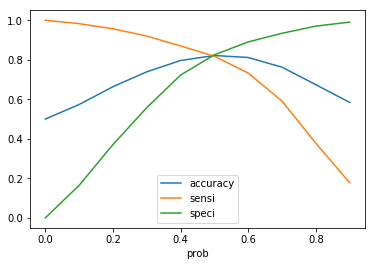

AUC on Test data 0.8531539158770408


In [49]:
y_train_pred_final,y_test_pred_final=model_build(LogisticRegression(),log_reg_params,df_train_pca,df_test_pca,y_sm,y_test)

In [50]:
#We are getting decent AUC of 85% on test data. By seeing the above table its safe to choose custoff at .3. It has relatively high sensitivity and also good specificity
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

In [51]:
y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [52]:
#Now lets validate our model and see what sensitivity and specifity we get on test data
validation_func(y_train_pred_final,y_test_pred_final)

Confusion metrics for train data [[ 712  564]
 [ 102 1174]]
Confusion metrics for test data [[4527 3601]
 [  46  485]]
Train accuracy 0.7390282131661442
Sensitivity of Train 0.9200626959247649
Specificity of train 0.5579937304075235
Calculate false postive rate - predicting churn when customer does not have churned for trian 0.44200626959247646
Test Accuracy 0.5788197251414713
Sensitivity of test 0.9133709981167608
Specificity of test 0.5569635826771654
Calculate false postive rate - predicting churn when customer does not have churned for test 0.44303641732283466


We got around 89-92% sensitivity on test data which is acceptable. False Positivies is ~42-45%. This means our model tend to predict 42-45% people no churners as churners.. Hmmm.. this is okay.. 

# 2. Random-Forest 

In [53]:
#lets try our hands with RandomForest
Ran_param_grid = {
    'max_depth': [12,16,20],
    'min_samples_leaf': range(50, 400, 50),
    'min_samples_split': range(50, 400, 50),
    'n_estimators': [30,50,70], 
    'max_features': [10,20]
}

Fitting 2 folds for each of 882 candidates, totalling 1764 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1764 out of 1764 | elapsed:  3.8min finished


We can get accuracy of 0.7974137931034483 using {'max_depth': 16, 'max_features': 10, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 70} for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
AUC on Train data 0.9026432031917926
      prob  accuracy  sensi  speci
0.00  0.00      0.50   1.00   0.00
0.10  0.10      0.55   1.00   0.10
0.20  0.20      0.64   0.99   0.30
0.30  0.30      0.73   0.96   0.51
0.40  0.40      0.81   0.89   0.72
0.50  0.50      0.83   0.81   0.85
0.60  0.60      0.81   0.69   0.92
0.70  0.70      0.75   0.54   0.96
0.80  0.80      0.67   0.35   0.98
0.90  0.90      0.56   0.1

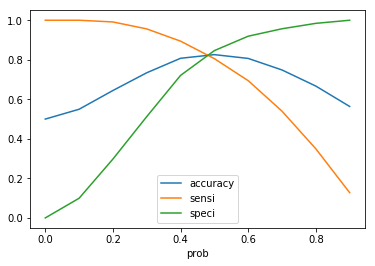

AUC on Test data 0.8432658675875261


In [54]:
y_train_pred_final,y_test_pred_final=model_build(RandomForestClassifier(),Ran_param_grid,df_train_pca,df_test_pca,y_sm,y_test)

In [55]:
#We are getting decent AUC of 85% on test data. By seeing the above table its safe to choose custoff at .3. It has relatively high sensitivity and also good specificity
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)
y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [56]:
#Now lets validate our model and see what sensitivity and specifity we get on test data
validation_func(y_train_pred_final,y_test_pred_final)

Confusion metrics for train data [[ 654  622]
 [  56 1220]]
Confusion metrics for test data [[3853 4275]
 [  44  487]]
Train accuracy 0.7343260188087775
Sensitivity of Train 0.9561128526645768
Specificity of train 0.512539184952978
Calculate false postive rate - predicting churn when customer does not have churned for trian 0.48746081504702193
Test Accuracy 0.5012126111560227
Sensitivity of test 0.9171374764595104
Specificity of test 0.4740403543307087
Calculate false postive rate - predicting churn when customer does not have churned for test 0.5259596456692913


We got around 90-94% sensitivity on test data which is acceptable. False Positivies is ~50-55%. This means our model tend to predict 50-55% people no churners as churners..

# 3. SVM 

In [57]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 3, shuffle = True, random_state = 4)
#lets perform SVM on thid data
svm_hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [0.1,1, 10, 100],'kernel':['linear','rbf']}]


# specify model
model = SVC()

In [58]:
# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid =svm_hyper_params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(df_train_pca,y_sm)  

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  9.1min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [59]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.8185611439841386 corresponding to hyperparameters {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}


In [60]:
#Lets build the model with best parameters
# model
model = SVC(C=0.1, gamma=0.0001, kernel="rbf")

model.fit(df_train_pca,y_sm)
y_pred_train=model.predict(df_train_pca)
y_pred= model.predict(df_test_pca)

# metrics
confusion_train=metrics.confusion_matrix(y_sm, y_pred_train)
confusion_test=metrics.confusion_matrix(y_test, y_pred)


In [61]:
#Train validations
TP_tr = confusion_train[1,1] # true positive 
TN_tr = confusion_train[0,0] # true negatives
FP_tr = confusion_train[0,1] # false positives
FN_tr = confusion_train[1,0] # false negatives


TP = confusion_test[1,1] # true positive 
TN = confusion_test[0,0] # true negatives
FP = confusion_test[0,1] # false positives
FN = confusion_test[1,0] # false negatives

print('Train accuracy',metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print('Sensitivity of Train',TP_tr / float(TP_tr+FN_tr))
print('Specificity of train',TN_tr / float(TN_tr+FP_tr))
print('Calculate false postive rate - predicting churn when customer does not have churned for trian',FP_tr/ float(TN_tr+FP_tr))

print('Test Accuracy',metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.final_predicted))
print('Sensitivity of test',TP / float(TP+FN))
print('Specificity of test',TN / float(TN+FP))
print('Calculate false postive rate - predicting churn when customer does not have churned for test',FP/ float(TN+FP))

Train accuracy 0.7343260188087775
Sensitivity of Train 0.9177115987460815
Specificity of train 0.39733542319749215
Calculate false postive rate - predicting churn when customer does not have churned for trian 0.6026645768025078
Test Accuracy 0.5012126111560227
Sensitivity of test 0.9322033898305084
Specificity of test 0.40723425196850394
Calculate false postive rate - predicting churn when customer does not have churned for test 0.5927657480314961


With SVM we are able to achieve 84-93% of sensitivity. But we are letting more non churn customers to be predicted as churn 

With Undersampling we always have risk of loosing data. But in our case it dosn't seem so. Let us try to see the result with Oversampling. Let us use SMOTE technique

# Handling class imbalance using smote

In [62]:
X_sm, y_sm = smote.fit_sample(X_train_n, y_train)

In [63]:
X_sm=pd.DataFrame(X_sm,columns=col)
X_sm=pd.DataFrame(X_sm,columns=col)
y_sm=pd.DataFrame({'churn':y_sm})

Lets perform PCA and find optimal features which gives us about 90% of varience. Lets also check the corelation between selected features. 

# PCA to reduce dimensionality

In [64]:
pca = PCA(svd_solver='randomized', random_state=42)

In [65]:
pca.fit(X_sm)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':col})

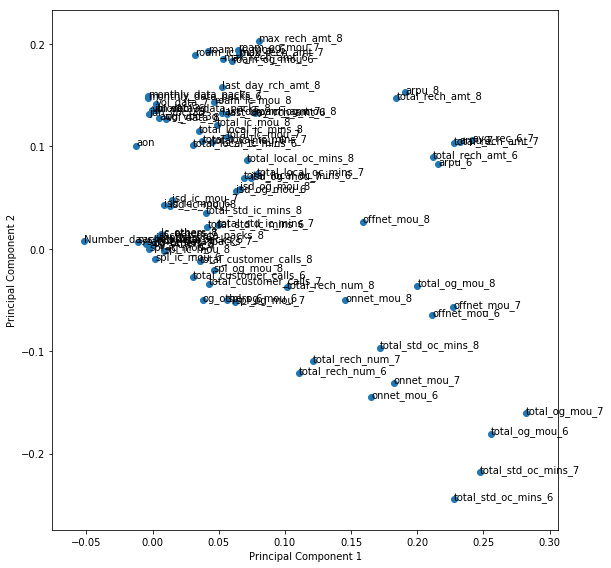

In [66]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

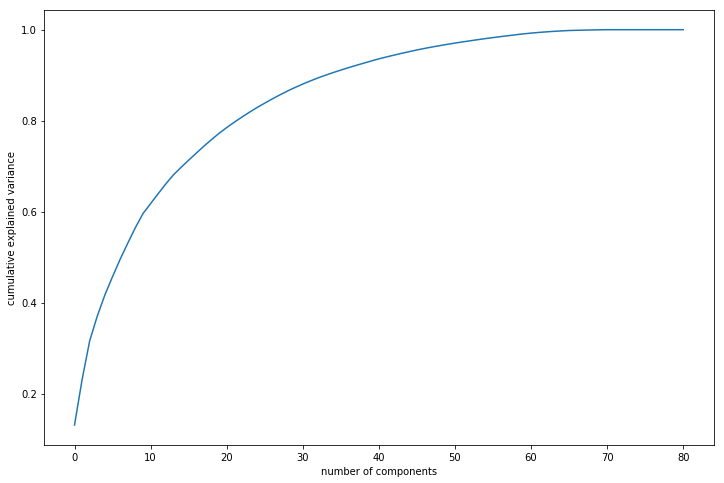

In [67]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [68]:
#Again around 35 features gives us 90% varience
pca_final = IncrementalPCA(n_components=35)

In [69]:
df_train_pca = pca_final.fit_transform(X_sm)
df_test_pca = pca_final.transform(X_test_n)

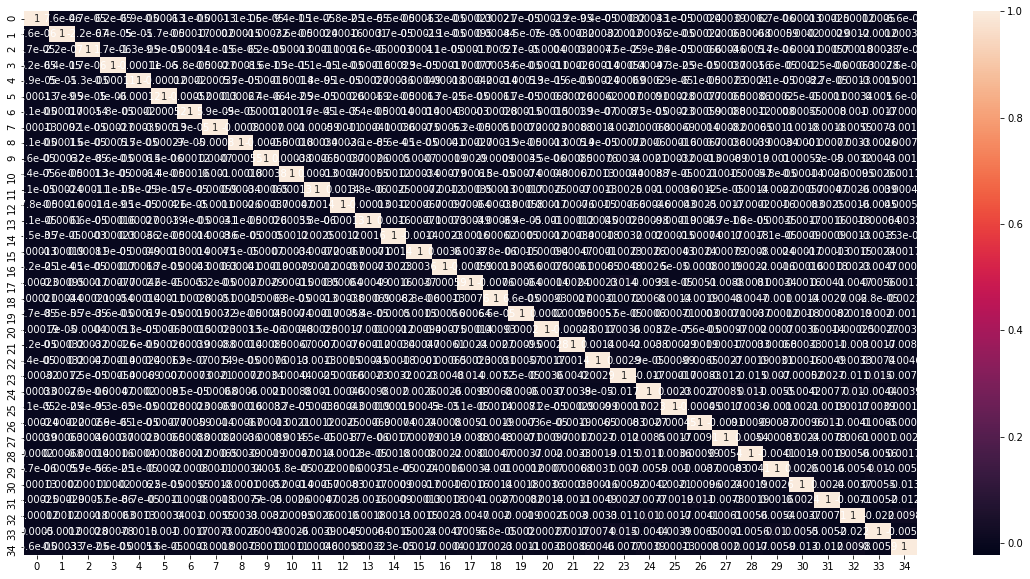

In [70]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [71]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.014710417149645274 , min corr:  -0.022327372529864272


# Logistic Model building

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   12.0s finished


We can get accuracy of 0.8285955827961534 using {'C': 0.01, 'penalty': 'l1'} for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
AUC on Train data 0.8861995576937867
      prob  accuracy  sensi  speci
0.00  0.00      0.50   1.00   0.00
0.10  0.10      0.62   0.98   0.26
0.20  0.20      0.71   0.95   0.47
0.30  0.30      0.77   0.92   0.62
0.40  0.40      0.81   0.88   0.74
0.50  0.50      0.83   0.83   0.83
0.60  0.60      0.82   0.76   0.88
0.70  0.70      0.79   0.66   0.92
0.80  0.80      0.72   0.49   0.95
0.90  0.90      0.60   0.23   0.98


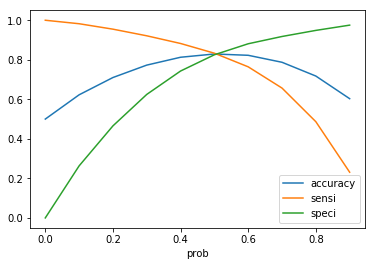

AUC on Test data 0.8496170499873956


In [72]:
#Corelation looks good
#Lets build Logistic Regression and RandomForest and tune them for max Sensitivity
#Building Logistic Regression
y_train_pred_final,y_test_pred_final=model_build(LogisticRegression(),log_reg_params,df_train_pca,df_test_pca,y_sm,y_test)

In [73]:
#We are getting decent AUC of 85% on test data. By seeing the above table its safe to choose custoff at .3. It has relatively high sensitivity and also good specificity
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)
y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [74]:
#Now lets validate our model and see what sensitivity and specifity we get on test data
validation_func(y_train_pred_final,y_test_pred_final)

Confusion metrics for train data [[11824  7102]
 [ 1489 17437]]
Confusion metrics for test data [[5096 3032]
 [  66  465]]
Train accuracy 0.7730370918313432
Sensitivity of Train 0.9213251611539681
Specificity of train 0.6247490225087181
Calculate false postive rate - predicting churn when customer does not have churned for trian 0.37525097749128183
Test Accuracy 0.6422219655849405
Sensitivity of test 0.8757062146892656
Specificity of test 0.6269685039370079
Calculate false postive rate - predicting churn when customer does not have churned for test 0.37303149606299213


Sensitivity of 87% on test data with 36% of False positive rate is a safe bet.

# Random Forest

As Random Forest took too much of time to run, we couldn't buuld the model. However running the below code will give Randomforest with SMOTE which also gives decent Sensitivity of arund 86-90%

In [75]:
#Lets build a RandomForest
# y_train_pred_final,y_test_pred_final=model_build(RandomForestClassifier(),Ran_param_grid,df_train_pca,df_test_pca,y_sm,y_test)

In [76]:
#We are getting decent AUC of 85% on test data. By seeing the above table its safe to choose custoff at .3. It has relatively high sensitivity and also good specificity
# y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)
# y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [77]:
#Now lets validate our model and see what sensitivity and specifity we get on test data
# validation_func(y_train_pred_final,y_test_pred_final)

# PCA Model Analysis

After creating different models using different sampling techniques we got below output

In [78]:
data=[['Under','Logistic Regression','89 -92%','43-50% '],['Under','Random Forest','90 -93%','50-55% '],['Under','SVC','84 -94%','24-34% '],['SMOTE','Logistic Regression','86 -89%','36-38% ']]
PCA_matrix=pd.DataFrame(data,columns=['Sampling','Models','Sensitivity','False Negatives'])
PCA_matrix

,Sampling,Models,Sensitivity,False Negatives
0,Under,Logistic Regression,89 -92%,43-50%
1,Under,Random Forest,90 -93%,50-55%
2,Under,SVC,84 -94%,24-34%
3,SMOTE,Logistic Regression,86 -89%,36-38%


NOTE:We have mentioned the range of the predictive values as every time we run the code, predictive values on test data is varying as train data is Under/Over sampled and each time we end up with different train data. But we are not seeing huge difference with the test predctivr values

Following points can be observed from above table(All are test predictors)

1.Random Forest built on Undersampling gives us the maximum Sensitivity most times. But it is at the cost of Predicting around 55% non churners as Churners

2.Logistic regression with Undersampling gives us sensitivity up to 92% and False prediction rate is also considerably less

3.SVC on undersampling is behaving vividly due to train sampling every time we run the code. But we are able to achieve Sensitivity anywhere between 84-94%. 

4.Logistic regression with SMOTE is giving us the most composed output with test sensitivity of 86-89% and very less false negatives around 36-38%


So from above points we can conclude
1. Random Forest with Under sampling can be used if Business is willing to burn money on non-churners also. This in turn will also give us high sensitivity which means that almost 93% of churners will be deducted but will also detect about 55% non churners as churners
2. Logistic Regression with SMOTE can be used if business is happy with 86-89% of sensitivity. Which means that only 86-89% of churners will be deducted. Whereas here we detect very least non churners as churners.
3. Logistic regression with Under sampling strikes a very well balance between sesitivity and False negatives. This can be a safe bet.


# Predicting data features for churning

In [79]:
#Lets check variables through Logistic Regression and feature selection through RFE
logreg = LogisticRegression(random_state=100)
rfe = RFE(logreg, 20)            
rfe = rfe.fit(X_train_scale, y_train)
rfecol=X_train.columns[rfe.support_]
# col=X_train.columns[rfe.support_]
logm1 = sm.GLM(y_train,(sm.add_constant(X_train_scale)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20121
Model Family:                Binomial   Df Model:                           80
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 17 Feb 2019   Deviance:                          nan
Time:                        22:23:06   Pearson chi2:                 1.43e+19
No. Iterations:                   100   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.993e+14   4.72e+05  -8.46e+08      0.000   -3.99e+14   -3.99e+14
x1         -6.136e+13   1.83e+06  -3.36e+07      0.000   -6.14e+13   -6.14e+13
x2          1.197e+14   1.97e+06   6.08e+07      0.000     1.2e+14     1.2e+14
x3          2.632e+14   2.15e+06   1.22e+08      0.000    2.63e+14    2.63e+14
x4         -1.543e+14   3.46e+07  -4.46e+06      0.000   -1.54e+14   -1.54e+14
x5         -1.104e+14   2.82e+07  -3.91e+06      0.000    -1.1e+14    -1.1e+14
x6          1.801e+12   2.47e+07   7.28e+04      0.000     1.8e+12     1.8e+12
x7         -2.317e+14   3.51e+07  -6.61e+06      0.000   -2.32e+14   -2.32e+14
x8          -1.12e+14   2.86e+07  -3.91e+06      0.000   -1.12e+14   -1.12e+14
x9          5.358e+13   2.54e+07   2.11e+06      0.000    5.36e+13    5.36e+13
x10         2.994e+13   7.05e+05   4.25e+07      0.000    2.99e+13    2.99e+13
x11        -5.319e+13    7.6e+05     -7e+07      0.000   -5.32e+13   -5.32e+13
x12         7.102e+12   6.99e+05   1.02e+07      0.000     7.1e+12     7.1e+12
x13         5.296e+13   8.95e+06   5.91e+06      0.000     5.3e+13     5.3e+13
x14         1.137e+14   5.89e+06   1.93e+07      0.000    1.14e+14    1.14e+14
x15        -5.331e+13   5.68e+06  -9.39e+06      0.000   -5.33e+13   -5.33e+13
x16        -8.772e+16   3.53e+09  -2.49e+07      0.000   -8.77e+16   -8.77e+16
x17        -2.507e+17   3.93e+09  -6.38e+07      0.000   -2.51e+17   -2.51e+17
x18         4.056e+17   3.75e+09   1.08e+08      0.000    4.06e+17    4.06e+17
x19        -2.913e+16   1.17e+09  -2.49e+07      0.000   -2.91e+16   -2.91e+16
x20        -1.054e+17   1.65e+09  -6.38e+07      0.000   -1.05e+17   -1.05e+17
x21         1.699e+17   1.57e+09   1.08e+08      0.000     1.7e+17     1.7e+17
x22        -3.915e+15   1.57e+08   -2.5e+07      0.000   -3.92e+15   -3.92e+15
x23        -9.399e+15   1.47e+08  -6.39e+07      0.000    -9.4e+15    -9.4e+15
x24         1.071e+16      1e+08   1.07e+08      0.000    1.07e+16    1.07e+16
x25         1.097e+18   4.41e+10   2.49e+07      0.000     1.1e+18     1.1e+18
x26         3.251e+18   5.09e+10   6.38e+07      0.000    3.25e+18    3.25e+18
x27        -5.388e+18   4.98e+10  -1.08e+08      0.000   -5.39e+18   -5.39e+18
x28         3.652e+17    2.5e+10   1.46e+07      0.000    3.65e+17    3.65e+17
x29         4.431e+17   2.72e+10   1.63e+07      0.000    4.43e+17    4.43e+17
x30        -4.826e+18   2.62e+10  -1.85e+08      0.000   -4.83e+18   -4.83e+18
x31         -2.06e+14   1.49e+07  -1.39e+07      0.000   -2.06e+14   -2.06e+14
x32        -1.922e+14   1.07e+07  -1.79e+07      0.000   -1.92e+14   -1.92e+14
x33         1.536e+15   8.59e+06   1.79e+08      0.000    1.54e+15    1.54e+15
x34        -6.475e+16   4.43e+09  -1.46e+07      0.000   -6.47e+16   -6.47e+16
x35        -9.106e+16   5.59e+09  -1.63e+07      0.000   -9.11e+16   -9.11e+16
x36          9.57e+17   5.19e+09   1.85e+08      0.000    9.57e+17    9.57e+17
x3

In [80]:
X_train_sm = sm.add_constant(X_train[rfecol])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20181
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3461.5
Date:                Sun, 17 Feb 2019   Deviance:                       6923.0
Time:                        22:23:07   Pearson chi2:                 1.25e+07
No. Iterations:                    13   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5354      0.078    -19.673      0.000      -1.688      -1.382
arpu_8                    0.0012      0.000      4.403      0.000       0.001       0.002
onnet_mou_7               0.0007   8.93e-05      8.182      0.000       0.001       0.001
onnet_mou_8               0.0007      0.000      3.843      0.000       0.000       0.001
offnet_mou_7              0.0010   8.03e-05     13.009      0.000       0.001       0.001
og_others_8              -3.7679      4.156     -0.907      0.365     -11.913       4.377
total_og_mou_8           -0.0020      0.000    -13.656      0.000      -0.002      -0.002
total_ic_mou_7            0.0011      0.000      6.381      0.000       0.001       0.001
total_ic_mou_8           -0.0029      0.001     -5.561      0.000      -0.004      -0.002
spl_ic_mou_8             -2.2172      0.476     -4.661      0.000      -3.150      -1.285
total_rech_amt_8         -0.0009      0.000     -4.216      0.000      -0.001      -0.000
max_rech_amt_8            0.0016      0.000      5.932      0.000       0.001       0.002
last_day_rch_amt_8       -0.0030      0.000     -7.644      0.000      -0.004      -0.002
aon                      -0.0003   4.41e-05     -7.271      0.000      -0.000      -0.000
monthly_data_packs_8     -1.1063      0.159     -6.964      0.000      -1.418      -0.795
sachet_data_packs_8      -0.1269      0.030     -4.282      0.000      -0.185      -0.069
vol_data_7                0.0002   5.58e-05      4.152      0.000       0.000       0.000
vol_data_8               -0.0004      0.000     -2.763      0.006      -0.001      -0.000
total_local_oc_mins_8    -0.0011      0.000     -6.036      0.000      -0.001      -0.001
total_local_ic_mins_8    -0.0008      0.000     -2.264      0.024      -0.001      -0.000
Number_days_not_rech      0.0355      0.004      9.734      0.000       0.028       0.043
=========================================================================================
"""

In [81]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfecol].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfecol].values, i) for i in range(X_train_sm[rfecol].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,total_rech_amt_8,28.51
0,arpu_8,28.35
7,total_ic_mou_8,11.32
5,total_og_mou_8,9.96
18,total_local_ic_mins_8,8.12
2,onnet_mou_8,7.08
6,total_ic_mou_7,5.47
10,max_rech_amt_8,4.61
16,vol_data_8,4.20
1,onnet_mou_7,3.83


In [82]:
rfecol = rfecol.drop('total_rech_amt_8', 1)

In [83]:
X_train_sm = sm.add_constant(X_train[rfecol])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20182
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3470.1
Date:                Sun, 17 Feb 2019   Deviance:                       6940.3
Time:                        22:23:09   Pearson chi2:                 2.87e+07
No. Iterations:                    13   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5225      0.078    -19.498      0.000      -1.676      -1.369
arpu_8                 5.394e-05   6.32e-05      0.854      0.393   -6.99e-05       0.000
onnet_mou_7               0.0007   8.89e-05      8.049      0.000       0.001       0.001
onnet_mou_8               0.0008      0.000      4.102      0.000       0.000       0.001
offnet_mou_7              0.0011   8.02e-05     13.171      0.000       0.001       0.001
og_others_8              -3.8202      4.225     -0.904      0.366     -12.101       4.461
total_og_mou_8           -0.0020      0.000    -13.444      0.000      -0.002      -0.002
total_ic_mou_7            0.0011      0.000      6.365      0.000       0.001       0.001
total_ic_mou_8           -0.0029      0.001     -5.461      0.000      -0.004      -0.002
spl_ic_mou_8             -2.2248      0.476     -4.673      0.000      -3.158      -1.292
max_rech_amt_8            0.0014      0.000      5.224      0.000       0.001       0.002
last_day_rch_amt_8       -0.0030      0.000     -7.474      0.000      -0.004      -0.002
aon                      -0.0003   4.41e-05     -7.059      0.000      -0.000      -0.000
monthly_data_packs_8     -1.0811      0.158     -6.837      0.000      -1.391      -0.771
sachet_data_packs_8      -0.1285      0.030     -4.336      0.000      -0.187      -0.070
vol_data_7                0.0002   5.55e-05      4.234      0.000       0.000       0.000
vol_data_8               -0.0003      0.000     -2.675      0.007      -0.001    -9.1e-05
total_local_oc_mins_8    -0.0010      0.000     -5.562      0.000      -0.001      -0.001
total_local_ic_mins_8    -0.0008      0.000     -2.501      0.012      -0.001      -0.000
Number_days_not_rech      0.0389      0.004     10.814      0.000       0.032       0.046
=========================================================================================
"""

In [84]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfecol].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfecol].values, i) for i in range(X_train_sm[rfecol].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,total_ic_mou_8,11.32
5,total_og_mou_8,9.96
17,total_local_ic_mins_8,8.12
2,onnet_mou_8,7.07
6,total_ic_mou_7,5.47
9,max_rech_amt_8,4.38
15,vol_data_8,4.20
0,arpu_8,4.03
1,onnet_mou_7,3.83
3,offnet_mou_7,3.78


In [85]:
rfecol = rfecol.drop('arpu_8', 1)

In [86]:
X_train_sm = sm.add_constant(X_train[rfecol])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20183
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3470.5
Date:                Sun, 17 Feb 2019   Deviance:                       6941.0
Time:                        22:23:12   Pearson chi2:                 3.39e+07
No. Iterations:                    13   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5221      0.078    -19.481      0.000      -1.675      -1.369
onnet_mou_7               0.0007   8.89e-05      8.031      0.000       0.001       0.001
onnet_mou_8               0.0008      0.000      4.096      0.000       0.000       0.001
offnet_mou_7              0.0011   8.01e-05     13.250      0.000       0.001       0.001
og_others_8              -3.8314      4.234     -0.905      0.366     -12.130       4.467
total_og_mou_8           -0.0019      0.000    -13.505      0.000      -0.002      -0.002
total_ic_mou_7            0.0011      0.000      6.355      0.000       0.001       0.001
total_ic_mou_8           -0.0028      0.001     -5.449      0.000      -0.004      -0.002
spl_ic_mou_8             -2.2313      0.476     -4.685      0.000      -3.165      -1.298
max_rech_amt_8            0.0015      0.000      6.208      0.000       0.001       0.002
last_day_rch_amt_8       -0.0030      0.000     -7.558      0.000      -0.004      -0.002
aon                      -0.0003   4.41e-05     -7.071      0.000      -0.000      -0.000
monthly_data_packs_8     -1.0803      0.158     -6.828      0.000      -1.390      -0.770
sachet_data_packs_8      -0.1278      0.030     -4.315      0.000      -0.186      -0.070
vol_data_7                0.0002   5.56e-05      4.221      0.000       0.000       0.000
vol_data_8               -0.0003      0.000     -2.671      0.008      -0.001   -9.05e-05
total_local_oc_mins_8    -0.0010      0.000     -5.564      0.000      -0.001      -0.001
total_local_ic_mins_8    -0.0008      0.000     -2.577      0.010      -0.001      -0.000
Number_days_not_rech      0.0388      0.004     10.794      0.000       0.032       0.046
=========================================================================================
"""

In [87]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfecol].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfecol].values, i) for i in range(X_train_sm[rfecol].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,total_ic_mou_8,11.29
4,total_og_mou_8,9.02
16,total_local_ic_mins_8,8.12
1,onnet_mou_8,7.07
5,total_ic_mou_7,5.47
14,vol_data_8,4.19
8,max_rech_amt_8,3.99
0,onnet_mou_7,3.83
2,offnet_mou_7,3.75
9,last_day_rch_amt_8,2.89


In [88]:
rfecol = rfecol.drop('total_local_ic_mins_8', 1)

In [89]:
X_train_sm = sm.add_constant(X_train[rfecol])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20184
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3473.6
Date:                Sun, 17 Feb 2019   Deviance:                       6947.2
Time:                        22:23:16   Pearson chi2:                 2.63e+07
No. Iterations:                    13   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5275      0.078    -19.531      0.000      -1.681      -1.374
onnet_mou_7               0.0007   8.89e-05      8.052      0.000       0.001       0.001
onnet_mou_8               0.0008      0.000      4.018      0.000       0.000       0.001
offnet_mou_7              0.0011   8.03e-05     13.253      0.000       0.001       0.001
og_others_8              -3.8482      4.283     -0.898      0.369     -12.243       4.547
total_og_mou_8           -0.0019      0.000    -13.362      0.000      -0.002      -0.002
total_ic_mou_7            0.0011      0.000      6.500      0.000       0.001       0.001
total_ic_mou_8           -0.0039      0.000    -10.556      0.000      -0.005      -0.003
spl_ic_mou_8             -2.2271      0.476     -4.676      0.000      -3.161      -1.294
max_rech_amt_8            0.0015      0.000      6.408      0.000       0.001       0.002
last_day_rch_amt_8       -0.0030      0.000     -7.589      0.000      -0.004      -0.002
aon                      -0.0003    4.4e-05     -7.238      0.000      -0.000      -0.000
monthly_data_packs_8     -1.0860      0.158     -6.860      0.000      -1.396      -0.776
sachet_data_packs_8      -0.1275      0.030     -4.306      0.000      -0.185      -0.069
vol_data_7                0.0002   5.56e-05      4.203      0.000       0.000       0.000
vol_data_8               -0.0003      0.000     -2.688      0.007      -0.001   -9.27e-05
total_local_oc_mins_8    -0.0011      0.000     -6.818      0.000      -0.001      -0.001
Number_days_not_rech      0.0389      0.004     10.803      0.000       0.032       0.046
=========================================================================================
"""

In [90]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfecol].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfecol].values, i) for i in range(X_train_sm[rfecol].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,total_og_mou_8,9.00
1,onnet_mou_8,7.07
6,total_ic_mou_8,5.60
5,total_ic_mou_7,5.46
14,vol_data_8,4.19
8,max_rech_amt_8,3.98
0,onnet_mou_7,3.83
2,offnet_mou_7,3.75
9,last_day_rch_amt_8,2.89
11,monthly_data_packs_8,2.79


In [91]:
rfecol = rfecol.drop('og_others_8', 1)

In [92]:
X_train_sm = sm.add_constant(X_train[rfecol])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20185
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3476.1
Date:                Sun, 17 Feb 2019   Deviance:                       6952.2
Time:                        22:23:18   Pearson chi2:                 2.59e+07
No. Iterations:                     8   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5265      0.078    -19.524      0.000      -1.680      -1.373
onnet_mou_7               0.0007   8.89e-05      8.050      0.000       0.001       0.001
onnet_mou_8               0.0008      0.000      4.011      0.000       0.000       0.001
offnet_mou_7              0.0011   8.01e-05     13.247      0.000       0.001       0.001
total_og_mou_8           -0.0019      0.000    -13.373      0.000      -0.002      -0.002
total_ic_mou_7            0.0011      0.000      6.516      0.000       0.001       0.001
total_ic_mou_8           -0.0039      0.000    -10.586      0.000      -0.005      -0.003
spl_ic_mou_8             -2.2234      0.476     -4.669      0.000      -3.157      -1.290
max_rech_amt_8            0.0015      0.000      6.423      0.000       0.001       0.002
last_day_rch_amt_8       -0.0030      0.000     -7.594      0.000      -0.004      -0.002
aon                      -0.0003    4.4e-05     -7.258      0.000      -0.000      -0.000
monthly_data_packs_8     -1.0887      0.158     -6.878      0.000      -1.399      -0.778
sachet_data_packs_8      -0.1282      0.030     -4.335      0.000      -0.186      -0.070
vol_data_7                0.0002   5.56e-05      4.207      0.000       0.000       0.000
vol_data_8               -0.0003      0.000     -2.682      0.007      -0.001   -9.19e-05
total_local_oc_mins_8    -0.0011      0.000     -6.849      0.000      -0.001      -0.001
Number_days_not_rech      0.0388      0.004     10.810      0.000       0.032       0.046
=========================================================================================
"""

In [93]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfecol].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfecol].values, i) for i in range(X_train_sm[rfecol].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,total_og_mou_8,9.00
1,onnet_mou_8,7.07
5,total_ic_mou_8,5.60
4,total_ic_mou_7,5.46
13,vol_data_8,4.18
7,max_rech_amt_8,3.98
0,onnet_mou_7,3.83
2,offnet_mou_7,3.75
8,last_day_rch_amt_8,2.89
10,monthly_data_packs_8,2.79


In [94]:
rfecol = rfecol.drop(['onnet_mou_8'], 1)

In [95]:
X_train_sm = sm.add_constant(X_train[rfecol])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20186
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3483.8
Date:                Sun, 17 Feb 2019   Deviance:                       6967.6
Time:                        22:23:19   Pearson chi2:                 3.64e+07
No. Iterations:                     8   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5252      0.078    -19.468      0.000      -1.679      -1.372
onnet_mou_7               0.0009   7.89e-05     11.269      0.000       0.001       0.001
offnet_mou_7              0.0009   7.27e-05     12.826      0.000       0.001       0.001
total_og_mou_8           -0.0015      0.000    -15.067      0.000      -0.002      -0.001
total_ic_mou_7            0.0011      0.000      6.726      0.000       0.001       0.001
total_ic_mou_8           -0.0040      0.000    -10.850      0.000      -0.005      -0.003
spl_ic_mou_8             -2.2820      0.476     -4.790      0.000      -3.216      -1.348
max_rech_amt_8            0.0016      0.000      6.598      0.000       0.001       0.002
last_day_rch_amt_8       -0.0028      0.000     -6.762      0.000      -0.004      -0.002
aon                      -0.0003    4.4e-05     -7.212      0.000      -0.000      -0.000
monthly_data_packs_8     -1.0905      0.159     -6.870      0.000      -1.402      -0.779
sachet_data_packs_8      -0.1275      0.030     -4.320      0.000      -0.185      -0.070
vol_data_7                0.0002   5.56e-05      4.201      0.000       0.000       0.000
vol_data_8               -0.0003      0.000     -2.684      0.007      -0.001   -9.24e-05
total_local_oc_mins_8    -0.0012      0.000     -7.242      0.000      -0.002      -0.001
Number_days_not_rech      0.0380      0.004     10.607      0.000       0.031       0.045
=========================================================================================
"""

In [96]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfecol].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfecol].values, i) for i in range(X_train_sm[rfecol].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,total_ic_mou_8,5.57
3,total_ic_mou_7,5.45
2,total_og_mou_8,5.10
12,vol_data_8,4.18
6,max_rech_amt_8,3.98
7,last_day_rch_amt_8,2.89
1,offnet_mou_7,2.80
9,monthly_data_packs_8,2.79
11,vol_data_7,2.57
0,onnet_mou_7,2.29


In [97]:
rfecol = rfecol.drop(['total_ic_mou_7'], 1)

In [98]:
X_train_sm = sm.add_constant(X_train[rfecol])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20187
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3505.9
Date:                Sun, 17 Feb 2019   Deviance:                       7011.8
Time:                        22:23:20   Pearson chi2:                 7.19e+07
No. Iterations:                     8   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.4637      0.078    -18.883      0.000      -1.616      -1.312
onnet_mou_7               0.0010   7.85e-05     12.384      0.000       0.001       0.001
offnet_mou_7              0.0010   7.08e-05     14.816      0.000       0.001       0.001
total_og_mou_8           -0.0017      0.000    -17.003      0.000      -0.002      -0.002
total_ic_mou_8           -0.0027      0.000     -9.113      0.000      -0.003      -0.002
spl_ic_mou_8             -2.3832      0.479     -4.976      0.000      -3.322      -1.444
max_rech_amt_8            0.0016      0.000      6.709      0.000       0.001       0.002
last_day_rch_amt_8       -0.0028      0.000     -6.928      0.000      -0.004      -0.002
aon                      -0.0003   4.38e-05     -7.289      0.000      -0.000      -0.000
monthly_data_packs_8     -1.0881      0.158     -6.875      0.000      -1.398      -0.778
sachet_data_packs_8      -0.1301      0.030     -4.408      0.000      -0.188      -0.072
vol_data_7                0.0002   5.42e-05      4.473      0.000       0.000       0.000
vol_data_8               -0.0004      0.000     -2.776      0.006      -0.001      -0.000
total_local_oc_mins_8    -0.0012      0.000     -7.396      0.000      -0.002      -0.001
Number_days_not_rech      0.0385      0.004     10.819      0.000       0.032       0.046
=========================================================================================
"""

In [99]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfecol].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfecol].values, i) for i in range(X_train_sm[rfecol].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,total_og_mou_8,4.93
11,vol_data_8,4.18
5,max_rech_amt_8,3.97
6,last_day_rch_amt_8,2.89
8,monthly_data_packs_8,2.79
1,offnet_mou_7,2.68
10,vol_data_7,2.57
7,aon,2.26
12,total_local_oc_mins_8,2.25
0,onnet_mou_7,2.23


We can stop here with feature deletion as VIF and P values are well within limit

In [100]:
y_train_pred=res.predict(X_train_sm).values.reshape(-1)

In [101]:
y_train_pred=pd.Series(y_train_pred).map(lambda x: 1 if x > 0.4 else 0)

In [102]:
print(metrics.accuracy_score(y_train, y_train_pred))

0.9346599346599347


In [103]:
X_test_rfe=X_test_n[rfecol]
X_test_rfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8659 entries, 0 to 8658
Data columns (total 14 columns):
onnet_mou_7              8659 non-null float64
offnet_mou_7             8659 non-null float64
total_og_mou_8           8659 non-null float64
total_ic_mou_8           8659 non-null float64
spl_ic_mou_8             8659 non-null float64
max_rech_amt_8           8659 non-null float64
last_day_rch_amt_8       8659 non-null float64
aon                      8659 non-null float64
monthly_data_packs_8     8659 non-null float64
sachet_data_packs_8      8659 non-null float64
vol_data_7               8659 non-null float64
vol_data_8               8659 non-null float64
total_local_oc_mins_8    8659 non-null float64
Number_days_not_rech     8659 non-null float64
dtypes: float64(14)
memory usage: 947.2 KB


# Independent Features Effecting Churn

In [104]:
Features=X_test_rfe.columns
Features

Index(['onnet_mou_7', 'offnet_mou_7', 'total_og_mou_8', 'total_ic_mou_8',
       'spl_ic_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'aon',
       'monthly_data_packs_8', 'sachet_data_packs_8', 'vol_data_7',
       'vol_data_8', 'total_local_oc_mins_8', 'Number_days_not_rech'],
      dtype='object')

Above are the features which effect Customer churn. Coeffiecients of these features are displayed below

In [105]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20202
Model:                            GLM   Df Residuals:                    20187
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3505.9
Date:                Sun, 17 Feb 2019   Deviance:                       7011.8
Time:                        22:23:22   Pearson chi2:                 7.19e+07
No. Iterations:                     8   Covariance Type:             nonrobust
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.4637      0.078    -18.883      0.000      -1.616      -1.312
onnet_mou_7               0.0010   7.85e-05     12.384      0.000       0.001       0.001
offnet_mou_7              0.0010   7.08e-05     14.816      0.000       0.001       0.001
total_og_mou_8           -0.0017      0.000    -17.003      0.000      -0.002      -0.002
total_ic_mou_8           -0.0027      0.000     -9.113      0.000      -0.003      -0.002
spl_ic_mou_8             -2.3832      0.479     -4.976      0.000      -3.322      -1.444
max_rech_amt_8            0.0016      0.000      6.709      0.000       0.001       0.002
last_day_rch_amt_8       -0.0028      0.000     -6.928      0.000      -0.004      -0.002
aon                      -0.0003   4.38e-05     -7.289      0.000      -0.000      -0.000
monthly_data_packs_8     -1.0881      0.158     -6.875      0.000      -1.398      -0.778
sachet_data_packs_8      -0.1301      0.030     -4.408      0.000      -0.188      -0.072
vol_data_7                0.0002   5.42e-05      4.473      0.000       0.000       0.000
vol_data_8               -0.0004      0.000     -2.776      0.006      -0.001      -0.000
total_local_oc_mins_8    -0.0012      0.000     -7.396      0.000      -0.002      -0.001
Number_days_not_rech      0.0385      0.004     10.819      0.000       0.032       0.046
=========================================================================================
"""

By seeing above we can understand spl_ic_mou_8 and monthly_data_packs_8 effect churn in most negative way. Which means any increase in these variables will not result in customer churn.
But from above we can also see that churn mostly depends on 8th month variables which is the action month. So analyzing and understanding these variables can help business in bringing out best offers

total_og_mou,total_ic_mou,Number_days_not_rech,aon,max_rech_amt,last_day_rch_amt and monthly_data_packs variables of 8th month are very important and needs to be monitored. Reduction in any of these features means that customer is not happy and is trying to move to other service. 
Reduction in Outgoing and incoming figures directly show that customer would have selected or trying to switch to new service provider. 
There are some features which will help us to detect the churners before action month also, they are volume of data used and offnet/onnet mou. 
In present day data usage is one of the most significant sefvice usage. SO any changes in it will directly give us a sign of churn. This might also be due to the pricing of data packs.

Proper monitoring of these features and taking necessary business actions will help in avoiding customer churn.
